In [1]:
import pandas as pd
import numpy as np
import nltk
import spacy
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score as sklearn_f1_score
from transformers import pipeline
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

print("Libraries installed")


Libraries installed


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# -------------------------------
# 1. Load Dataset
# -------------------------------

In [3]:
# Load the job description dataset
data = pd.read_csv("/content/drive/MyDrive/Universtiy of London/Final Project/job_descriptions.csv")
print("Original Data Preview:")


# Sampling 500 job descriptions for testing
small_data = data.sample(n=9500, random_state=42)
print(small_data.head())
# Saving the sample for testing
# small_data.to_csv('small_sample.csv', index=False)

Original Data Preview:
                   Job Id     Experience Qualifications Salary Range  \
108318   1017340707950150  5 to 10 Years            BBA    $55K-$84K   
7787     2421048253959975  0 to 12 Years            MBA   $61K-$108K   
1237496  1822636506606589  0 to 11 Years          M.Com    $57K-$82K   
55757    3068000579894602  5 to 12 Years          B.Com    $56K-$95K   
818970   1747904829392680  4 to 13 Years            BCA   $58K-$122K   

                location   Country  latitude  longitude  Work Type  \
108318       Panama City    Panama    8.5379   -80.7821   Contract   
7787               Tunis   Tunisia   33.8869     9.5375  Part-Time   
1237496           Harare  Zimbabwe  -19.0154    29.1549  Full-Time   
55757             Tirana   Albania   41.1533    20.1683  Temporary   
818970   City of Baghdad      Iraq   33.2232    43.6793  Temporary   

         Company Size  ...              Contact                 Job Title  \
108318          93242  ...         242.271.445

# -------------------------------
# 2. Preprocess Dataset
# -------------------------------

In [5]:
!nvidia-smi

Tue Mar 25 14:47:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   49C    P8             17W /   72W |       3MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm", disable=["ner", "textcat"])

# Text Preprocessing Function
def preprocess_docs(texts):
    docs = nlp.pipe([text.lower() for text in texts], batch_size=128)
    preprocessed = []
    for doc in docs:
        tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
        preprocessed.append(" ".join(tokens))
    return preprocessed

# Apply to the whole dataset efficiently
small_data['processed'] = preprocess_docs(small_data['Job Description'].tolist())

# --------------------------------------
# 3. Keyword Extraction Using TF-IDF
# --------------------------------------

In [5]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=20)  # Extract top 20 keywords

# Fit and transform the preprocessed text
tfidf_matrix = tfidf_vectorizer.fit_transform(small_data['processed'])

# Get the top keywords for each job description
keywords = []
feature_names = tfidf_vectorizer.get_feature_names_out()

for row in tfidf_matrix:
    top_indices = np.argsort(row.toarray()).flatten()[-5:]  # Top 5 keywords
    top_keywords = [feature_names[i] for i in top_indices]
    keywords.append(", ".join(top_keywords))

# Add the keywords as a new column
small_data['TF-IDF Keywords'] = keywords

print(small_data[['Job Description', 'TF-IDF Keywords']].head())

                                           Job Description  \
108318   Promote diversity and inclusion in the supply ...   
7787     Architectural Drafters assist architects and e...   
1237496  An Art Education Coordinator plans and manages...   
55757    Environmental Impact Analysts assess the envir...   
818970   An Art Education Coordinator plans and manages...   

                                TF-IDF Keywords  
108318      support, user, system, work, manage  
7787        support, user, work, design, create  
1237496     support, user, system, work, manage  
55757    support, work, provide, datum, analyze  
818970      support, user, system, work, manage  


# -----------------------------------------------
# 4. Named Entity Recognition (NER) Extraction
# -----------------------------------------------

In [6]:
# Function to extract NER entities (skills, qualifications, job titles)
def extract_ner(text):
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents if ent.label_ in ["ORG", "PERSON", "GPE", "WORK_OF_ART", "PRODUCT"]]
    return ", ".join(entities)

# Apply NER extraction to job descriptions
small_data['NER Keywords'] = small_data['Job Description'].apply(extract_ner)

print(small_data[['Job Description', 'NER Keywords']].head())

                                           Job Description NER Keywords
108318   Promote diversity and inclusion in the supply ...             
7787     Architectural Drafters assist architects and e...             
1237496  An Art Education Coordinator plans and manages...             
55757    Environmental Impact Analysts assess the envir...             
818970   An Art Education Coordinator plans and manages...             


# ------------------------------------------------------------
# 5. Semantic Extraction and Similarity Using BERT
# ------------------------------------------------------------

In [7]:
# Load BERT pipeline
semantic_extractor = pipeline("feature-extraction", model="bert-base-uncased", device=-1)
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

# Function to extract BERT-based keywords using noun chunks
def extract_bert_keywords(text, top_n=5):
    # Extract noun chunks with spaCy
    doc = nlp(text.lower())
    candidates = [token.text for token in doc if token.pos_ in ["NOUN", "PROPN", "ADJ"] and not token.is_stop and not token.is_punct]
    return ", ".join(candidates[:top_n])

# Apply BERT-based extraction with spaCy chunks (first 5 rows for runtime efficiency)
small_data['BERT Keywords'] = small_data['Job Description'].apply(extract_bert_keywords)

print("\nSimplified BERT Keywords Preview:")
print(small_data[['Job Description', 'BERT Keywords']].head())


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Device set to use cpu



Simplified BERT Keywords Preview:
                                           Job Description  \
108318   Promote diversity and inclusion in the supply ...   
7787     Architectural Drafters assist architects and e...   
1237496  An Art Education Coordinator plans and manages...   
55757    Environmental Impact Analysts assess the envir...   
818970   An Art Education Coordinator plans and manages...   

                                             BERT Keywords  
108318       diversity, inclusion, supply, chain, supplier  
7787     architectural, drafters, architects, engineers...  
1237496            art, education, coordinator, plans, art  
55757    environmental, impact, analysts, environmental...  
818970             art, education, coordinator, plans, art  


# ------------------------------------------------
# 6. Search Strategy Query Generation
# ------------------------------------------------

In [8]:
# Combine all keywords into search queries
def generate_search_query(tfidf, ner):
    query_terms = set(tfidf.split(", ") + ner.split(", "))
    return " AND ".join(query_terms)

small_data['Search Strategy'] = small_data.apply(lambda x: generate_search_query(x['TF-IDF Keywords'], x['NER Keywords']), axis=1)
print("\nGenerated Search Strategies:")
print(small_data[['Job Description', 'Search Strategy']].head())


Generated Search Strategies:
                                           Job Description  \
108318   Promote diversity and inclusion in the supply ...   
7787     Architectural Drafters assist architects and e...   
1237496  An Art Education Coordinator plans and manages...   
55757    Environmental Impact Analysts assess the envir...   
818970   An Art Education Coordinator plans and manages...   

                                           Search Strategy  
108318    AND system AND support AND manage AND work AN...  
7787      AND support AND work AND design AND user AND ...  
1237496   AND system AND support AND manage AND work AN...  
55757     AND support AND analyze AND datum AND work AN...  
818970    AND system AND support AND manage AND work AN...  


# ------------------------------------------------
# 6. Save the Results
# ------------------------------------------------

In [9]:
# Save the final DataFrame to a CSV file
small_data.to_csv('processed_job_descriptions.csv', index=False)

print("All steps completed! The results have been saved to 'processed_job_descriptions.csv'.")

All steps completed! The results have been saved to 'processed_job_descriptions.csv'.


# ------------------------------------------------
# 7. Visual Comparison of Results
# ------------------------------------------------

In [10]:
# Side-by-Side Comparison Table
comparison_df = small_data[['Job Description', 'TF-IDF Keywords', 'NER Keywords', 'BERT Keywords', 'Search Strategy']].head()
print("\nComparison of Methods:")
print(comparison_df)


Comparison of Methods:
                                           Job Description  \
108318   Promote diversity and inclusion in the supply ...   
7787     Architectural Drafters assist architects and e...   
1237496  An Art Education Coordinator plans and manages...   
55757    Environmental Impact Analysts assess the envir...   
818970   An Art Education Coordinator plans and manages...   

                                TF-IDF Keywords NER Keywords  \
108318      support, user, system, work, manage                
7787        support, user, work, design, create                
1237496     support, user, system, work, manage                
55757    support, work, provide, datum, analyze                
818970      support, user, system, work, manage                

                                             BERT Keywords  \
108318       diversity, inclusion, supply, chain, supplier   
7787     architectural, drafters, architects, engineers...   
1237496            art, educatio

# ------------------------------------------------
# 8. Evaluation Metrics
# ------------------------------------------------

## -----------------------------------------------
## 8.1 Load and Prepare Dataset
## ------------------------------------------------

In [11]:
# Extract only the 'Job Description' and 'skills' columns
data = small_data[['Job Description', 'skills']]

# Display the extracted columns to ensure data is loaded correctly
print("First 5 rows of the dataset:")
print(data.head())

# Save the selected columns to a new CSV file for reference
data.to_csv('job_description_skills.csv', index=False)

First 5 rows of the dataset:
                                           Job Description  \
108318   Promote diversity and inclusion in the supply ...   
7787     Architectural Drafters assist architects and e...   
1237496  An Art Education Coordinator plans and manages...   
55757    Environmental Impact Analysts assess the envir...   
818970   An Art Education Coordinator plans and manages...   

                                                    skills  
108318   Supplier diversity programs Diversity and incl...  
7787     Architectural drafting AutoCAD 2D and 3D model...  
1237496  Art education curriculum Program development T...  
55757    Environmental impact analysis Data collection ...  
818970   Art education curriculum Program development T...  


## ------------------------------------------------
## 8.2 Text Preprocessing using spaCy
## ------------------------------------------------

In [12]:
# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Define preprocessing function
def preprocess(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

# Apply preprocessing to 'Job Description'
data['processed'] = data['Job Description'].apply(preprocess)

# Display processed text
print("Processed Job Descriptions:")
print(data[['Job Description', 'processed']].head())


Processed Job Descriptions:
                                           Job Description  \
108318   Promote diversity and inclusion in the supply ...   
7787     Architectural Drafters assist architects and e...   
1237496  An Art Education Coordinator plans and manages...   
55757    Environmental Impact Analysts assess the envir...   
818970   An Art Education Coordinator plans and manages...   

                                                 processed  
108318   promote diversity inclusion supply chain manag...  
7787     architectural drafter assist architect enginee...  
1237496  art education coordinator plan manage art educ...  
55757    environmental impact analyst assess environmen...  
818970   art education coordinator plan manage art educ...  


<ipython-input-12-d5311f47b808>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['processed'] = data['Job Description'].apply(preprocess)


## ------------------------------------------------
## 8.3 Generate Ground Truth Keywords
## ------------------------------------------------

In [37]:
# Fixed: Create Ground Truth Dictionary with Tokenization and Cleaning
def create_ground_truth(skills_column, nlp):
    ground_truth = {}
    for idx, skills in enumerate(skills_column):
        if pd.isna(skills):
            ground_truth[idx] = []
            continue
        # Split the string into chunks (assuming comma or newline or semicolon separators)
        chunks = re.split(r'[,\n;]', skills)
        keywords = []
        for chunk in chunks:
            doc = nlp(chunk.strip().lower())
            tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
            keywords.extend(tokens)
        ground_truth[idx] = keywords
    return ground_truth



##### Old Ground Truth generator:
# Create Ground Truth Dictionary with Lemmatization and Cleaning
# def create_ground_truth(skills_column, nlp):
#     ground_truth = {}
#     for idx, skills in enumerate(skills_column):
#         # Process and clean each skill
#         doc = nlp(skills.lower())
#         keywords = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
#         ground_truth[idx] = keywords
#     return ground_truth

# Generate Ground Truth from 'skills' column
# ground_truth = create_ground_truth(data['skills'], nlp)

# Display ground truth for verification
print("Ground Truth (first 5 rows):")
for idx in range(5):
    print(f"Row {idx}: {ground_truth[idx]}")


Ground Truth (first 5 rows):
Row 0: ['supplier diversity programs diversity and inclusion initiatives supplier assessment and certification data collection and reporting vendor outreach and engagement strategic planning communication skills relationship building attention to diversity and inclusion principles']
Row 1: ['architectural drafting autocad 2d and 3d modeling blueprint reading building codes collaboration with architects detail-oriented']
Row 2: ['art education curriculum program development teacher training communication skills artistic expertise']
Row 3: ['environmental impact analysis data collection and analysis environmental regulations reporting gis (geographic information systems) technical writing']
Row 4: ['art education curriculum program development teacher training communication skills artistic expertise']


In [40]:
import re

# Generate Ground Truth from 'skills' column
ground_truth = create_ground_truth(data['skills'], nlp)

## ------------------------------------------------
## 8.4 TF-IDF Keyword Extraction
## ------------------------------------------------

In [41]:
# TF-IDF Keyword Extraction
vectorizer = TfidfVectorizer(max_features=5)
tfidf_keywords = []

# Extract top keywords for each processed text
for text in data['processed']:
    tfidf_matrix = vectorizer.fit_transform([text])
    feature_names = [word.lower() for word in vectorizer.get_feature_names_out()]
    tfidf_keywords.append(list(feature_names))

# Display TF-IDF keywords for first 5 rows
print("TF-IDF Keywords (first 5 rows):")
for idx, keywords in enumerate(tfidf_keywords[:5]):
    print(f"Row {idx}: {keywords}")


TF-IDF Keywords (first 5 rows):
Row 0: ['assess', 'chain', 'diversity', 'manage', 'supplier']
Row 1: ['accurate', 'aid', 'architectural', 'assist', 'drawing']
Row 2: ['appreciation', 'art', 'community', 'coordinator', 'education']
Row 3: ['activity', 'adverse', 'analyst', 'assess', 'environmental']
Row 4: ['appreciation', 'art', 'community', 'coordinator', 'education']


## ------------------------------------------------
## 8.5 NER-Based Keyword Extraction
## ------------------------------------------------

In [42]:
# NER-Based Keyword Extraction
def extract_ner_keywords(text):
    doc = nlp(text)
    keywords = [chunk.text.lower() for chunk in doc.noun_chunks]
    return keywords[:5]  # Return top 5 noun chunks

# Apply NER extraction
ner_keywords = data['processed'].apply(extract_ner_keywords)

# Display NER-based keywords
print("NER-Based Keywords (first 5 rows):")
for idx, keywords in enumerate(ner_keywords[:5]):
    print(f"Row {idx}: {keywords}")

NER-Based Keywords (first 5 rows):
Row 0: ['diversity inclusion supply chain', 'supplier diversity program', 'supplier performance']
Row 1: ['architectural drafter', 'architect engineer', 'detailed technical drawing plan building structure', 'computer aid design cad software', 'accurate precise architectural drawing']
Row 2: ['art education coordinator plan', 'art education program curriculum development educational outreach', 'art appreciation', 'community']
Row 3: ['environmental impact analyst', 'environmental consequence project activity conduct study analyze datum', 'recommendation minimize adverse environmental effect', 'sustainable practice']
Row 4: ['art education coordinator plan', 'art education program curriculum development educational outreach', 'art appreciation', 'community']


## ------------------------------------------------
## 8.6 BERT-Based Keyword Extraction
## ------------------------------------------------

In [43]:
# BERT-Based Keyword Extraction using Noun Chunks
def extract_bert_keywords(text, n=5):
    doc = nlp(text)
    keywords = [chunk.text.lower() for chunk in doc.noun_chunks]
    return keywords[:n]

# Apply BERT-based keyword extraction
bert_keywords = data['processed'].apply(lambda x: extract_bert_keywords(x, n=5))

# Display BERT-based keywords for first 5 rows
print("BERT-Based Keywords (first 5 rows):")
for idx, keywords in enumerate(bert_keywords[:5]):
    print(f"Row {idx}: {keywords}")


BERT-Based Keywords (first 5 rows):
Row 0: ['diversity inclusion supply chain', 'supplier diversity program', 'supplier performance']
Row 1: ['architectural drafter', 'architect engineer', 'detailed technical drawing plan building structure', 'computer aid design cad software', 'accurate precise architectural drawing']
Row 2: ['art education coordinator plan', 'art education program curriculum development educational outreach', 'art appreciation', 'community']
Row 3: ['environmental impact analyst', 'environmental consequence project activity conduct study analyze datum', 'recommendation minimize adverse environmental effect', 'sustainable practice']
Row 4: ['art education coordinator plan', 'art education program curriculum development educational outreach', 'art appreciation', 'community']


## ------------------------------------------------
## 8.7 Evaluation Metrics Calculation
## ------------------------------------------------

In [44]:
# Evaluation Metrics Calculation with Cleanup
def calculate_metrics(predicted, ground_truth):
    precision, recall, f1_results = [], [], []
    for i, keywords in enumerate(predicted):
        if i in ground_truth:
            # Clean and align predicted keywords
            predicted_cleaned = [word.strip().lower() for word in keywords]
            ground_truth_cleaned = ground_truth[i]

            # Binary ground-truth match
            y_true = [1 if word in ground_truth_cleaned else 0 for word in predicted_cleaned]
            y_pred = [1] * len(predicted_cleaned)

            if sum(y_true) > 0:  # Handle edge cases where ground truth exists
                precision.append(precision_score(y_true, y_pred))
                recall.append(recall_score(y_true, y_pred))
                f1_results.append(sklearn_f1_score(y_true, y_pred))  # Use sklearn_f1_score
            else:
                precision.append(0)
                recall.append(0)
                f1_results.append(0)
    return np.mean(precision), np.mean(recall), np.mean(f1_results)


In [50]:
print("Length of tfidf_keywords:", len(tfidf_keywords))
print("Length of ner_keywords:", len(ner_keywords))
print("Length of bert_keywords:", len(bert_keywords))


Length of tfidf_keywords: 9500
Length of ner_keywords: 9500
Length of bert_keywords: 9500


In [51]:
print("Type of tfidf_keywords:", type(tfidf_keywords))
print("Type of ner_keywords:", type(ner_keywords))
print("Type of bert_keywords:", type(bert_keywords))


Type of tfidf_keywords: <class 'list'>
Type of ner_keywords: <class 'pandas.core.series.Series'>
Type of bert_keywords: <class 'pandas.core.series.Series'>


In [52]:
print("First 3 items in tfidf_keywords:", tfidf_keywords[:3])


First 3 items in tfidf_keywords: [['assess', 'chain', 'diversity', 'manage', 'supplier'], ['accurate', 'aid', 'architectural', 'assist', 'drawing'], ['appreciation', 'art', 'community', 'coordinator', 'education']]


## ------------------------------------------------
## 8.8 Combined keywords Evaluation
## ------------------------------------------------

In [53]:
# Convert Series to lists to ensure proper indexing
ner_keywords = ner_keywords.tolist()
bert_keywords = bert_keywords.tolist()

# Combine all keyword outputs
combined_keywords = []
for idx in range(len(tfidf_keywords)):
    combined = set(tfidf_keywords[idx]) | set(ner_keywords[idx]) | set(bert_keywords[idx])
    combined_keywords.append(list(combined))

# Tokenize multi-word phrases to align with ground truth
combined_keywords_tokenized = flatten_and_tokenize(combined_keywords)

# Evaluate
combined_precision, combined_recall, combined_f1 = calculate_metrics(combined_keywords_tokenized, ground_truth)

print("\n✅ Combined Evaluation:")
print(f"Precision: {combined_precision:.2f}, Recall: {combined_recall:.2f}, F1-Score: {combined_f1:.2f}")




✅ Combined Evaluation:
Precision: 0.29, Recall: 1.00, F1-Score: 0.44


## ------------------------------------------------
## 8.9 Evaluate and Compare TF-IDF, NER and BERT
## ------------------------------------------------

In [47]:
# Evaluate TF-IDF Keywords
tfidf_precision, tfidf_recall, tfidf_f1 = calculate_metrics(tfidf_keywords, ground_truth)
print("\nTF-IDF Evaluation:")
print(f"Precision: {tfidf_precision:.2f}, Recall: {tfidf_recall:.2f}, F1-Score: {tfidf_f1:.2f}")

# Evaluate NER Keywords
ner_precision, ner_recall, ner_f1 = calculate_metrics(ner_keywords, ground_truth)
print("\nNER-Based Evaluation:")
print(f"Precision: {ner_precision:.2f}, Recall: {ner_recall:.2f}, F1-Score: {ner_f1:.2f}")

# Evaluate BERT-Based Keywords
bert_precision, bert_recall, bert_f1 = calculate_metrics(bert_keywords, ground_truth)
print("\nBERT-Based Evaluation:")
print(f"Precision: {bert_precision:.2f}, Recall: {bert_recall:.2f}, F1-Score: {bert_f1:.2f}")



TF-IDF Evaluation:
Precision: 0.37, Recall: 0.96, F1-Score: 0.52

NER-Based Evaluation:
Precision: 0.03, Recall: 0.09, F1-Score: 0.04

BERT-Based Evaluation:
Precision: 0.03, Recall: 0.09, F1-Score: 0.04


## ------------------------------------------------
## 9 Visual Comparison
## ------------------------------------------------

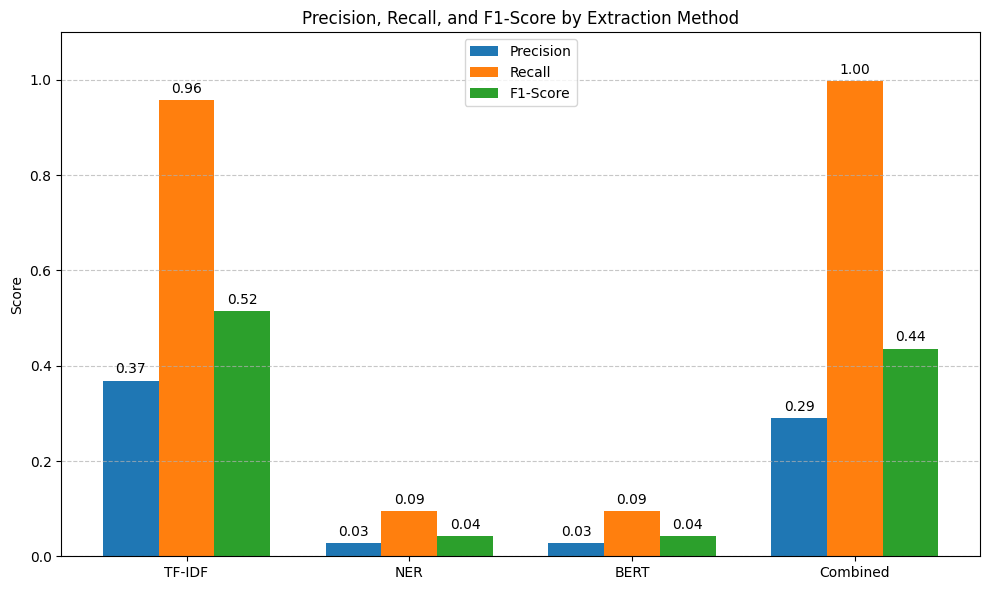

In [54]:
# Updated Evaluation Chart with Combined Approach

methods = ['TF-IDF', 'NER', 'BERT', 'Combined']
precision_scores = [tfidf_precision, ner_precision, bert_precision, combined_precision]
recall_scores = [tfidf_recall, ner_recall, bert_recall, combined_recall]
f1_scores = [tfidf_f1, ner_f1, bert_f1, combined_f1]

x = np.arange(len(methods))  # label locations
width = 0.25  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, precision_scores, width, label='Precision')
bars2 = ax.bar(x, recall_scores, width, label='Recall')
bars3 = ax.bar(x + width, f1_scores, width, label='F1-Score')

# Add labels and title
ax.set_ylabel('Score')
ax.set_title('Precision, Recall, and F1-Score by Extraction Method')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.set_ylim([0, 1.1])
ax.legend()

# Add value labels on top of bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
